### **Imports**

In [914]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

### **Loading and Exploration**

In [915]:
df_raw = pd.read_csv('data/data.csv')

C:\Users\gray-owl\AppData\Local\Temp\ipykernel_4608\561397643.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('data/data.csv')


### **Formattage des colonnes**

**Format column names**

In [916]:
# mettre les nom des colonnes sous forme de xxx-yyy
cols = df_raw.columns.str.lower()
cols = cols.str.replace(r'\W', '-', regex=True)
cols = cols.str.replace(r'à', 'a', regex=True)
cols = cols.str.replace(r'é|è', 'e', regex=True)

df_clean = df_raw.copy()
df_clean.columns = cols
df_clean.columns[:4]

Index(['titre', 'localisation', 'prix', 'annee-modele'], dtype='object')

**prix**

In [917]:
df_p = df_clean.copy()

prix = df_clean['prix'].str.extract(r"(.*)\s*DH")[0]
prix_clean = prix.str.replace(r'\s+', '', regex=True)
df_p['prix'] = prix_clean.astype('Int64')  # Nullable Int64 type

print(df_p['prix'].head(2))

0     78000
1    170000
Name: prix, dtype: Int64


In [918]:
df_p['kilometrage']

0        250 000 - 299 999
1          25 000 - 29 999
2        300 000 - 349 999
3          15 000 - 19 999
4        180 000 - 189 999
               ...        
34194    100 000 - 109 999
34195                  NaN
34196                  NaN
34197                  NaN
34198                  NaN
Name: kilometrage, Length: 34199, dtype: object

**kilometrage moyen**

In [919]:
df_km = df_p.copy()

# Step 1: Remove whitespace
km_col = df_p['kilometrage'].str.replace(r'\s', '', regex=True)

# Step 2: Try to extract ranges like "250000-299999"
range_df = km_col.str.extract(r'(\d+)-(\d+)').astype(float)
km_mean = range_df.mean(axis=1)

# Step 3: Fallback — extract any number (e.g., "Plusde500000")
fallback = km_col.str.extract(r'(\d+)').astype(float)
km_mean.fillna(fallback[0], inplace=True)

# Step 4: Assign cleaned values
df_km['kilometrage'] = km_mean.round().astype('Int64')


print(df_km['kilometrage'].head())

0    275000
1     27500
2    325000
3     17500
4    185000
Name: kilometrage, dtype: Int64


**Convertir la puissance fiscale en un entier**

In [920]:
df_pf = df_km.copy()

df_pf['puissance-fiscale'] = df_km['puissance-fiscale'].str.replace(r'\D', '', regex=True)
df_pf['puissance-fiscale'] = pd.to_numeric(df_pf['puissance-fiscale']).astype('Int64', errors='ignore')
df_pf['puissance-fiscale'].head()

0    6
1    5
2    8
3    8
4    6
Name: puissance-fiscale, dtype: Int64

**annee-model**

In [921]:
df_am = df_pf.copy()

def extract_year(val):
    if isinstance(val, str):
        match = re.search(r'\d{4}', val)
        return int(match.group()) if match else np.nan
    elif isinstance(val, float) and not np.isnan(val):
        return int(val)
    elif isinstance(val, int):
        return val
    return np.nan

df_am['annee-modele'] = df_am['annee-modele'].apply(extract_year).astype('Int64')

df_am['annee-modele'].head()

0    2010
1    2023
2    2005
3    2020
4    2015
Name: annee-modele, dtype: Int64

**Premiere main**

In [922]:
df_pm = df_am.copy()

df_pm['premiere-main'] = (
    df_am['premiere-main']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({'oui': True, 'non': False})
    .where(lambda x: x.isin([True, False]), pd.NA)
    .astype('boolean')
)

df_pm['premiere-main'].head()

0    False
1    False
2    False
3     True
4    False
Name: premiere-main, dtype: boolean

**nombre-de-portes**

In [923]:
df_np = df_pm.copy()

df_np['nombre-de-portes'] = df_np['nombre-de-portes'].astype('Int64')
df_np['nombre-de-portes'].head()

0    5
1    5
2    5
3    5
4    5
Name: nombre-de-portes, dtype: Int64

In [924]:
df_np.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34199 entries, 0 to 34198
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   titre                               33854 non-null  object 
 1   localisation                        33738 non-null  object 
 2   prix                                33736 non-null  Int64  
 3   annee-modele                        33640 non-null  Int64  
 4   boite-de-vitesses                   33493 non-null  object 
 5   type-de-carburant                   33642 non-null  object 
 6   kilometrage                         33629 non-null  Int64  
 7   marque                              33628 non-null  object 
 8   modele                              33628 non-null  object 
 9   nombre-de-portes                    29896 non-null  Int64  
 10  origine                             29614 non-null  object 
 11  premiere-main                       29038

### **Imputation**

In [925]:
df_imp = df_np.copy()
df_imp.isna().sum().where(lambda x: x > 0).dropna().sort_values(ascending=False)

premiere-main        5161.0
origine              4585.0
nombre-de-portes     4303.0
etat                 1871.0
puissance-fiscale     723.0
boite-de-vitesses     706.0
modele                571.0
marque                571.0
kilometrage           570.0
annee-modele          559.0
type-de-carburant     557.0
prix                  463.0
localisation          461.0
titre                 345.0
dtype: float64

#### origine

In [926]:
df_imp['origine'] = df_imp['origine'].fillna(df_imp['origine'].mode()[0])
df_imp['origine'].isna().sum()

np.int64(0)

#### nombre-de-portes

In [927]:
df_imp['nombre-de-portes'] = df_imp['nombre-de-portes'].fillna(df_imp['nombre-de-portes'].mode()[0])
df_imp['nombre-de-portes'].isna().sum()

np.int64(0)

#### type-de-carburant

In [928]:
df_imp['type-de-carburant'] = df_imp['type-de-carburant'].fillna(df_imp['type-de-carburant'].mode()[0])
df_imp['type-de-carburant'].isna().sum()

np.int64(0)

#### kilometrage

In [929]:
df_imp['kilometrage'] = df_imp['kilometrage'].fillna(df_imp['kilometrage'].mode()[0])
df_imp['kilometrage'].isna().sum()

np.int64(0)

#### annee-model

In [930]:
df_imp['annee-modele'] = df_imp['annee-modele'].fillna(df_imp['annee-modele'].mode()[0])
df_imp['annee-modele'].isna().sum()

np.int64(0)

#### etat

L'état est liée au kilométrage. Alors on impute cette état à partir du valeur
du kilométrage.

On test trois modèle pour prédire l'etat à partir de kilométrage et on choisit
celui qui prédit le mieux.

##### **Random Forest**

In [931]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

tmp_df = df_imp.copy()
tmp_df = tmp_df[tmp_df['etat'].notna() & tmp_df['kilometrage'].notna()]

# Encodage de la variable 'etat' en valeurs numériques
le = LabelEncoder()
tmp_df['etat_encoded'] = le.fit_transform(tmp_df['etat'])

X = tmp_df[['kilometrage']]
y = tmp_df['etat_encoded'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

         Bon       0.42      0.04      0.07      1352
     Correct       0.00      0.00      0.00       199
   Endommagé       0.00      0.00      0.00         4
   Excellent       0.50      0.78      0.61      4246
        Neuf       0.00      0.00      0.00       337
 Pour Pièces       0.00      0.00      0.00         6
    Très bon       0.44      0.36      0.40      3555

    accuracy                           0.48      9699
   macro avg       0.19      0.17      0.15      9699
weighted avg       0.44      0.48      0.42      9699



##### **Linear Regression**

In [932]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

etat_order = [
    'Pour Pièces',
    'Endommagé',
    'Correct',
    'Bon',
    'Très bon',
    'Excellent',
    'Neuf'
]

etat_map = {etat: i for i, etat in enumerate(etat_order)}
inv_etat_map = {v: k for k, v in etat_map.items()}

df = df_imp.copy()

df = df[df['etat'].notna() & df['kilometrage'].notna()]
df['etat_encoded'] = df['etat'].map(etat_map)

X = df[['kilometrage']]
y = df['etat_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_pred_rounded = y_pred.round().clip(0, len(etat_order) - 1).astype(int)

y_test_labels = y_test.map(inv_etat_map)
y_pred_labels = pd.Series(y_pred_rounded).map(inv_etat_map)

print(classification_report(y_test_labels, y_pred_labels, labels=etat_order, zero_division=0))

              precision    recall  f1-score   support

 Pour Pièces       0.00      0.00      0.00         4
   Endommagé       0.00      0.00      0.00         2
     Correct       0.00      0.00      0.00       137
         Bon       0.00      0.00      0.00       935
    Très bon       0.38      0.84      0.52      2364
   Excellent       0.41      0.17      0.25      2795
        Neuf       0.00      0.00      0.00       229

    accuracy                           0.38      6466
   macro avg       0.11      0.14      0.11      6466
weighted avg       0.31      0.38      0.30      6466



##### **Decision Tree**

In [933]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report

etat_order = [
    'Pour Pièces', 'Endommagé', 'Correct', 'Bon',
    'Très bon', 'Excellent', 'Neuf'
]

etat_map = {etat: i for i, etat in enumerate(etat_order)}
inv_etat_map = {v: k for k, v in etat_map.items()}

df = df_imp.copy()

df = df[df['etat'].notna() & df['kilometrage'].notna()]
df['etat_encoded'] = df['etat'].map(etat_map)

X = df[['kilometrage']]
y = df['etat_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
y_pred_rounded = y_pred.round().clip(0, len(etat_order) - 1).astype(int)

y_test_labels = y_test.map(inv_etat_map)
y_pred_labels = pd.Series(y_pred_rounded).map(inv_etat_map)

print(classification_report(y_test_labels, y_pred_labels, labels=etat_order, zero_division=0))

              precision    recall  f1-score   support

 Pour Pièces       0.00      0.00      0.00         4
   Endommagé       0.00      0.00      0.00         2
     Correct       0.00      0.00      0.00       137
         Bon       0.00      0.00      0.00       935
    Très bon       0.38      0.81      0.52      2364
   Excellent       0.56      0.29      0.38      2795
        Neuf       0.00      0.00      0.00       229

    accuracy                           0.42      6466
   macro avg       0.13      0.16      0.13      6466
weighted avg       0.38      0.42      0.35      6466



#### **Conclusion**

Le modèle Decision Tree nous donne une précision dans les deux classes (Très Bon et Excellent) plus mieux que LinearRegression et RandomForest.

#### **Imputation de etat avec Decision Tree**

In [934]:
df_etat = df_imp.copy()

etat_null_df = df_imp[df_imp['etat'].isna()]
y_pred = dt_model.predict(etat_null_df[['kilometrage']])
etat_pred = pd.Series(y_pred).round().clip(0, len(etat_order) - 1).astype(int)
etat_pred_labels = etat_pred.map(inv_etat_map)
etat_pred_labels.unique()

array(['Très bon', 'Excellent'], dtype=object)

In [935]:
df_etat.loc[df_imp['etat'].isna(), 'etat'] = etat_pred_labels.values
df_etat['etat'].isna().sum()

np.int64(0)

#### marque

On remarque que parfois, la marque est incluse dans le titre de l'annonce des voitures.

Alors, on impute la marque à partir du titre en cherchant si elle existe une marque -de celles
déja presente dans le dataset- dans le titre, si oui on precède à l'imputation.

In [936]:
df_marque = df_etat.copy()

marques = df_marque['marque'].str.lower().dropna().unique()

def fill_missing_marques(df, marques):
    mask = df['marque'].isna()
    titres = df.loc[mask, 'titre'].str.lower().fillna('')
    for m in marques:
        match = titres.str.contains(m, na=False)
        df.loc[mask & match, 'marque'] = m

print("Missing values in 'marque' before:", df_marque['marque'].isna().sum())
fill_missing_marques(df_marque, marques)
print("Missing values in 'marque' after:", df_marque['marque'].isna().sum())

Missing values in 'marque' before: 571
Missing values in 'marque' after: 515


#### **boite-a-vitesse**

In [937]:
df_boite = df_marque.copy()

simpleImputer = SimpleImputer(strategy='most_frequent')
df_boite['boite-de-vitesses'] = simpleImputer.fit_transform(df_boite[['boite-de-vitesses']]).ravel()
df_boite['boite-de-vitesses'].isna().sum()

np.int64(0)

#### **premiere-main**

In [938]:
df_prem = df_boite.copy()

simpleImputer = SimpleImputer(strategy='most_frequent')
df_prem['premiere-main'] = simpleImputer.fit_transform(df_prem[['premiere-main']]).ravel()
df_prem['premiere-main'].isna().sum()

np.int64(0)

#### **puissqnce-fiscale**

In [939]:
df_puiss = df_prem.copy()

simpleImputer = SimpleImputer(strategy='most_frequent')
df_puiss['puissance-fiscale'] = simpleImputer.fit_transform(
    df_puiss[['puissance-fiscale']]).ravel()
df_puiss['puissance-fiscale'].isna().sum()

np.int64(0)

In [940]:
df_puiss.isna().sum()

titre                                 345
localisation                          461
prix                                  463
annee-modele                            0
boite-de-vitesses                       0
type-de-carburant                       0
kilometrage                             0
marque                                515
modele                                571
nombre-de-portes                        0
origine                                 0
premiere-main                           0
puissance-fiscale                       0
etat                                    0
abs                                     0
airbags                                 0
cd-mp3-bluetooth                        0
camera-de-recul                         0
climatisation                           0
esp                                     0
jantes-aluminium                        0
limiteur-de-vitesse                     0
ordinateur-de-bord                      0
radar-de-recul                    

### **Suppression des valeurs nulles**

In [941]:
sub_set = df_puiss.isna().sum().where(lambda x: x > 0).dropna().index
print(sub_set)
df_puiss = df_puiss.dropna(subset=sub_set)

Index(['titre', 'localisation', 'prix', 'marque', 'modele'], dtype='object')


In [942]:
df_puiss.isna().sum().where(lambda x : x > 0).dropna()
print(df_puiss.shape)

(33628, 30)


### **Ajout des colonnnes**

**Age**

In [943]:
df_add = df_puiss.copy()

df_add['age'] = 2025 - df_puiss['annee-modele']

### **Suppression des colonnes**

In [944]:
cols = ['titre', 'localisation', 'annee-modele']

df_suppr = df_add.drop(columns=cols)

df_suppr.shape

(33628, 28)

### **Valeurs aberrantes**

In [945]:
df_aberr = df_suppr.copy()

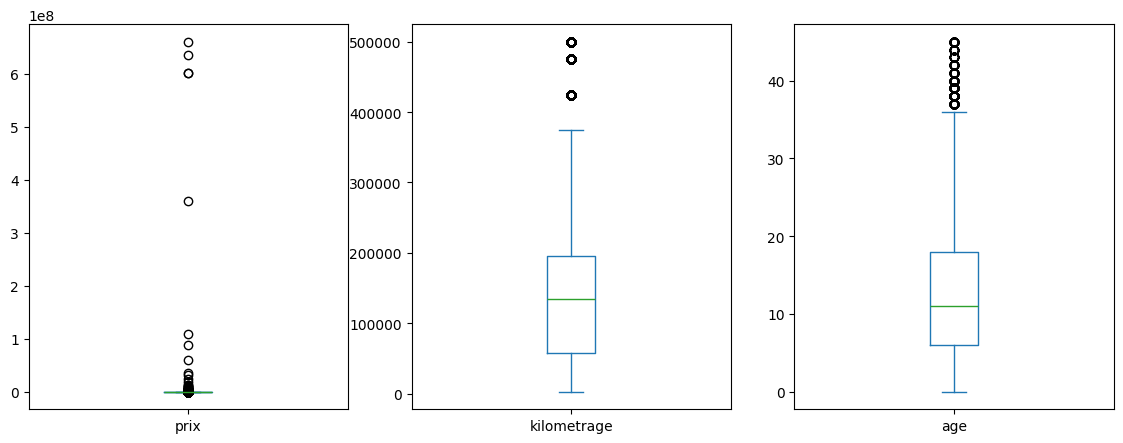

In [946]:
cols = ['prix', 'kilometrage', 'age']
df_aberr[cols].plot(kind='box', subplots=True, layout=(1, len(cols)), figsize=(14, 5));

#### **Prix**

##### **Methode de l'interquartile**

In [947]:
# isr is not suitable for skewed data

q1 = df_aberr['prix'].quantile(0.25)
q3 = df_aberr['prix'].quantile(0.75)
iqr = q3 - q1
min = q1 - 1.5 * iqr
max = q3 + 1.5 * iqr
df_iqr = df_aberr[(df_aberr['prix'] >= min ) & (df_aberr['prix'] <= max)]
print(df_aberr.shape)
print(df_iqr.shape)
df_iqr['prix'].describe().to_frame().T

(33628, 28)
(31538, 28)


,count,mean,std,min,25%,50%,75%,max
prix,31538.0,118588.334137,72932.367236,450.0,60000.0,105000.0,159999.0,340000.0


##### **Isolation Forest**

In [948]:
# iso is suitable for skewed data

df_iso = df_aberr.copy()

# 4% of data flagged as outliers
iso = IsolationForest(contamination=0.04, random_state=42)
df_iso['outlier'] = iso.fit_predict(df_aberr[['prix']])

# Identify outliers for visualization (before filtering)
outliers = df_iso['outlier'] == -1  # Boolean mask for outliers

# Filter out the outliers (keep rows where outlier == 1) and drop the 'outlier' column
df_iso = df_iso[df_iso['outlier'] == 1].drop(columns='outlier')

print("Before:", df.shape)
print("After :", df_iso.shape)

df_iso['prix'].describe().to_frame().T

Before: (32328, 31)
After : (32282, 28)


,count,mean,std,min,25%,50%,75%,max
prix,32282.0,125466.882721,82461.402176,11700.0,62000.0,110000.0,165000.0,415000.0


Text(0.5, 1.0, 'Isolation Forest Method')

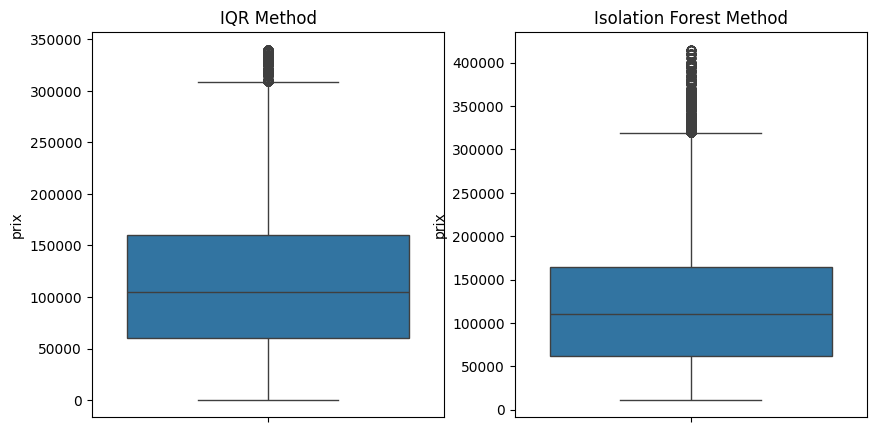

In [949]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(df_iqr, y='prix', ax=ax1)
ax1.set_title('IQR Method')

sns.boxplot(df_iso, y='prix', ax=ax2)
ax2.set_title('Isolation Forest Method')

### **Data cleaned**

In [950]:
df_final = df_iso.copy()
df_final.to_csv('data/data_cleaned.csv', index=False)